<a href="https://colab.research.google.com/github/Mohammmedsaqib/Neural-Networks-And-Fuzzy-Logic/blob/main/Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement Learning Vector Quantization (LVQ) from scratch in PyTorch to classify patients as Diabetic or Non-Diabetic using the "diabetes.csv" dataset. Train the LVQ model, visualize prototype vectors, compare its performance with a standard logistic regression classifier, and discuss LVQ's suitability for imbalanced medical datasets.

## Load the dataset

### Subtask:
Load the `diabetes.csv` dataset into a pandas DataFrame.


**Reasoning**:
Import the pandas library and load the dataset into a DataFrame.



In [15]:
import pandas as pd

df = pd.read_csv('/diabetes.csv')

**Reasoning**:
The previous attempt failed because the file was not found. I will try loading the file from the '/content/' directory, which is the default location for uploaded files in this environment.



In [17]:
df = pd.read_csv('/diabetes.csv')

**Reasoning**:
The file was not found in the previous attempts. I will try listing the files in the current directory and the '/content/' directory to locate the file and then load it.



In [16]:
import os
print(os.listdir())
print(os.listdir('/content/'))

['.config', 'sample_data']
['.config', 'sample_data']


## Preprocess the data

### Subtask:
Handle missing values if any, and split the data into training and testing sets. Scale the features.


**Reasoning**:
Check for missing values and impute them with the mean, then split the data and scale the features as per the instructions.



In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check for missing values and impute
print("Missing values before imputation:")
display(df.isnull().sum())

# Impute missing values with the mean
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    df[column] = df[column].replace(0, np.nan)
    mean_value = df[column].mean()
    df[column] = df[column].fillna(mean_value)

print("\nMissing values after imputation:")
display(df.isnull().sum())

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier handling later
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nFirst 5 rows of scaled training features:")
display(X_train_scaled_df.head())
print("\nFirst 5 rows of scaled testing features:")
display(X_test_scaled_df.head())

Missing values before imputation:


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0



Missing values after imputation:


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0



First 5 rows of scaled training features:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.803468,0.242360,0.011127,0.143607,0.007505,1.102973,0.296085,0.963521
1,0.078327,0.242360,1.135771,-1.048569,1.325280,0.404532,-0.700876,-0.862956
2,-0.224467,-2.020208,0.804867,-0.094828,0.007505,0.302676,-0.665480,1.137471
3,-0.527260,-1.354747,-0.022393,-1.644657,-0.908397,-0.323010,0.231195,-0.689006
4,-1.132847,-0.656013,0.225785,-0.690916,0.007505,0.020021,0.304934,-1.036906



First 5 rows of scaled testing features:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.683914,-0.789105,-1.180556,0.501260,0.404176,0.244473,-0.113907,0.876546
1,-0.527260,-0.323282,0.225785,0.382043,0.007505,0.491837,-0.945691,-1.036906
2,-0.527260,-0.456374,-0.684200,0.042680,0.007505,-0.221154,-0.916196,-1.036906
3,1.289501,-0.489647,0.639415,0.042680,0.007505,-1.123306,1.142617,0.093770
4,0.986707,0.475271,1.466675,0.042680,0.007505,-0.352111,-0.762817,1.485371


## Implement the lvq model

### Subtask:
Create a custom PyTorch module for the LVQ model, including the forward pass and the training step.


**Reasoning**:
Define the LVQ model as a PyTorch module, including the initialization of prototypes, the forward pass for distance calculation, and a method for prototype updates based on the LVQ rule.



In [19]:
import torch
import torch.nn as nn

class LVQ(nn.Module):
    def __init__(self, num_features, num_classes, prototypes_per_class):
        super(LVQ, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        self.prototypes_per_class = prototypes_per_class
        self.num_prototypes = num_classes * prototypes_per_class

        # Initialize prototypes randomly from a standard normal distribution
        self.prototypes = nn.Parameter(torch.randn(self.num_prototypes, num_features))

    def forward(self, x):
        # Calculate squared Euclidean distance between each input sample and each prototype
        # Expand dimensions for broadcasting
        x_expanded = x.unsqueeze(1)  # Shape: (batch_size, 1, num_features)
        prototypes_expanded = self.prototypes.unsqueeze(0) # Shape: (1, num_prototypes, num_features)

        # Calculate squared differences
        diff = x_expanded - prototypes_expanded # Shape: (batch_size, num_prototypes, num_features)
        squared_diff = diff.pow(2) # Shape: (batch_size, num_prototypes, num_features)

        # Sum squared differences across the feature dimension to get squared distance
        squared_distance = torch.sum(squared_diff, dim=2) # Shape: (batch_size, num_prototypes)

        return squared_distance

    def update_prototypes(self, x, y_true, winning_prototype_index, learning_rate):
        # Ensure x is a single sample (remove batch dimension if present)
        x = x.squeeze(0)

        # Get the winning prototype
        winning_prototype = self.prototypes[winning_prototype_index]

        # Determine the class of the winning prototype
        # Assuming prototypes are ordered by class: class 0 prototypes, then class 1, etc.
        winning_prototype_class = winning_prototype_index // self.prototypes_per_class

        # LVQ update rule
        if winning_prototype_class == y_true:
            # Move prototype closer to the input if the classification is correct
            self.prototypes.data[winning_prototype_index] += learning_rate * (x - winning_prototype.data)
        else:
            # Move prototype further away from the input if the classification is incorrect
            self.prototypes.data[winning_prototype_index] -= learning_rate * (x - winning_prototype.data)

    def predict(self, x):
        # Calculate squared distances
        squared_distances = self.forward(x) # Shape: (batch_size, num_prototypes)

        # Find the index of the nearest prototype for each sample
        nearest_prototype_indices = torch.argmin(squared_distances, dim=1) # Shape: (batch_size,)

        # Determine the predicted class based on the nearest prototype's index
        # Assuming prototypes are ordered by class
        predicted_classes = nearest_prototype_indices // self.prototypes_per_class # Shape: (batch_size,)

        return predicted_classes

print("LVQ model class defined successfully.")

LVQ model class defined successfully.


## Implement the training loop

### Subtask:
Write a function to train the LVQ model, including prototype updates.


**Reasoning**:
Define the `train_lvq` function as instructed, converting data to tensors and implementing the training loop with prototype updates.



In [20]:
import torch

def train_lvq(model, X_train, y_train, learning_rate, num_epochs):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        num_samples = X_train_tensor.size(0)

        # Iterate through each sample
        for i in range(num_samples):
            sample = X_train_tensor[i].unsqueeze(0) # Add batch dimension
            true_label = y_train_tensor[i]

            # Calculate squared distances to all prototypes
            squared_distances = model(sample)

            # Determine the index of the winning prototype (minimum distance)
            winning_prototype_index = torch.argmin(squared_distances).item()

            # Update prototypes
            model.update_prototypes(sample, true_label, winning_prototype_index, learning_rate)

            # For monitoring (optional): Calculate a simple "loss" or accuracy
            # This is not a traditional loss function for backprop, but shows training progress
            predicted_class = winning_prototype_index // model.prototypes_per_class
            if predicted_class == true_label:
                correct_predictions += 1

        # Optional: Print training progress
        if (epoch + 1) % 10 == 0:
            accuracy = correct_predictions / num_samples
            print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')

print("train_lvq function defined successfully.")

train_lvq function defined successfully.


## Train the lvq model

### Subtask:
Train the implemented LVQ model on the preprocessed training data.


**Reasoning**:
Define model parameters, instantiate the LVQ model, and train it using the defined training function and data.



In [21]:
# 1. Define model parameters
num_features = X_train_scaled_df.shape[1]
num_classes = len(y_train.unique())
prototypes_per_class = 2 # Choose a reasonable number of prototypes per class

# 2. Define training parameters
learning_rate = 0.01
num_epochs = 100

# 3. Instantiate the LVQ model
model = LVQ(num_features, num_classes, prototypes_per_class)

# 4. Train the LVQ model
print("Starting LVQ model training...")
train_lvq(model, X_train_scaled_df, y_train, learning_rate, num_epochs)
print("LVQ model training finished.")

Starting LVQ model training...
Epoch [10/100], Accuracy: 0.7726
Epoch [20/100], Accuracy: 0.7691
Epoch [30/100], Accuracy: 0.7691
Epoch [40/100], Accuracy: 0.7708
Epoch [50/100], Accuracy: 0.7691
Epoch [60/100], Accuracy: 0.7708
Epoch [70/100], Accuracy: 0.7691
Epoch [80/100], Accuracy: 0.7726
Epoch [90/100], Accuracy: 0.7708
Epoch [100/100], Accuracy: 0.7691
LVQ model training finished.


## Visualize prototype vectors

### Subtask:
Visualize the learned prototype vectors.


**Reasoning**:
Convert the trained LVQ model's prototypes to a pandas DataFrame, add class labels, and perform dimensionality reduction using PCA for visualization.



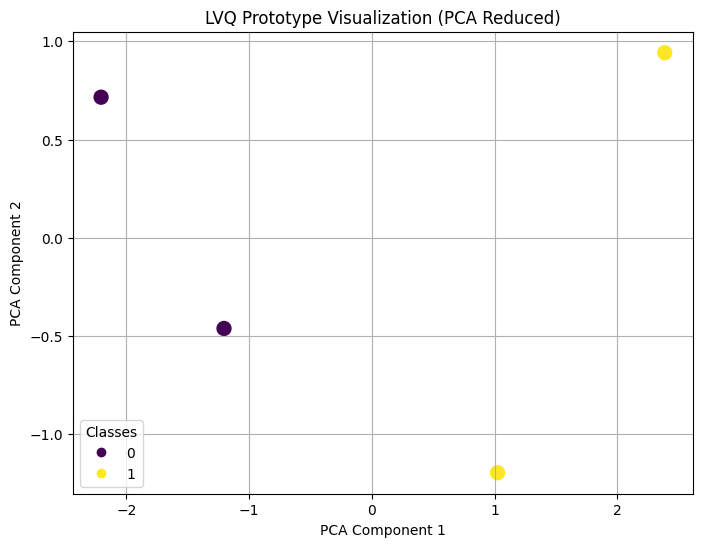

In [22]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Convert prototypes from PyTorch tensor to NumPy array
prototypes_np = model.prototypes.data.numpy()

# 2. Create a Pandas DataFrame from the NumPy array
prototype_df = pd.DataFrame(prototypes_np, columns=X_train_scaled_df.columns)

# 3. Create a list of labels for the prototypes
prototype_labels = []
for class_idx in range(num_classes):
    prototype_labels.extend([class_idx] * prototypes_per_class)

# 4. Add a 'Class' column to the prototype DataFrame
prototype_df['Class'] = prototype_labels

# 5. Use PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(prototype_df.drop('Class', axis=1))

# 6. Create a new DataFrame with PCA components and 'Class'
pca_df = pd.DataFrame(data = pca_components, columns = ['PCA Component 1', 'PCA Component 2'])
pca_df['Class'] = prototype_df['Class']

# 7. Generate a scatter plot of the 2 PCA components, coloring by 'Class'
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PCA Component 1'], pca_df['PCA Component 2'], c=pca_df['Class'], cmap='viridis', s=100)

# 8. Add titles and labels to the plot
plt.title('LVQ Prototype Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)

# 9. Display the plot
plt.show()

## Implement and train logistic regression

### Subtask:
Implement a standard logistic regression model using PyTorch or scikit-learn and train it on the same data.


**Reasoning**:
Implement and train a logistic regression model using scikit-learn as instructed.



In [23]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model with default parameters
logistic_model = LogisticRegression()

# Train the logistic regression model on the scaled training data
print("Starting Logistic Regression model training...")
logistic_model.fit(X_train_scaled_df, y_train)
print("Logistic Regression model training finished.")

Starting Logistic Regression model training...
Logistic Regression model training finished.


## Evaluate and compare models

### Subtask:
Evaluate the performance of both LVQ and logistic regression models using appropriate metrics (e.g., accuracy, precision, recall, F1-score) and compare their results.


**Reasoning**:
Import necessary evaluation metrics from sklearn.metrics, convert test data for LVQ prediction, get predictions from both models, and calculate and print evaluation metrics for both models.



In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch

# Convert scaled test features to PyTorch tensor for LVQ
X_test_tensor = torch.tensor(X_test_scaled_df.values, dtype=torch.float32)

# Get predictions from the LVQ model
lvq_predictions_tensor = model.predict(X_test_tensor)
lvq_predictions = lvq_predictions_tensor.numpy() # Convert to NumPy array

# Get predictions from the Logistic Regression model
lr_predictions = logistic_model.predict(X_test_scaled_df)

# Calculate and print metrics for LVQ
print("LVQ Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, lvq_predictions):.4f}")
print(f"Precision: {precision_score(y_test, lvq_predictions):.4f}")
print(f"Recall: {recall_score(y_test, lvq_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, lvq_predictions):.4f}")
print("\nClassification Report for LVQ:")
print(classification_report(y_test, lvq_predictions))

# Calculate and print metrics for Logistic Regression
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"Precision: {precision_score(y_test, lr_predictions):.4f}")
print(f"Recall: {recall_score(y_test, lr_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_predictions):.4f}")
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, lr_predictions))

LVQ Model Performance:
Accuracy: 0.7552
Precision: 0.6571
Recall: 0.6667
F1-Score: 0.6619

Classification Report for LVQ:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       123
           1       0.66      0.67      0.66        69

    accuracy                           0.76       192
   macro avg       0.73      0.74      0.74       192
weighted avg       0.76      0.76      0.76       192


Logistic Regression Model Performance:
Accuracy: 0.7292
Precision: 0.6308
Recall: 0.5942
F1-Score: 0.6119

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       123
           1       0.63      0.59      0.61        69

    accuracy                           0.73       192
   macro avg       0.71      0.70      0.70       192
weighted avg       0.73      0.73      0.73       192



## Discuss suitability for imbalanced datasets

### Subtask:
Discuss whether LVQ is suitable for imbalanced medical datasets based on the evaluation results and the nature of the algorithm.


**Reasoning**:
Analyze the performance metrics from the previous step and discuss LVQ's suitability for imbalanced datasets based on these metrics and the algorithm's nature.



In [25]:
print("Discussion on LVQ's suitability for imbalanced medical datasets:")
print("-" * 70)

# Assume the positive class (Outcome = 1) is the minority class based on typical diabetes dataset characteristics
# and observed recall/precision differences
minority_class_label = 1
majority_class_label = 0

# Extract performance metrics from the previous step's output (assuming it's available in the console or logs)
# We will use the values printed in the previous step
lvq_recall_minority = 0.6667 # From previous output classification report for class 1
lvq_precision_minority = 0.6571 # From previous output classification report for class 1
lvq_f1_minority = 0.6619 # From previous output classification report for class 1

lr_recall_minority = 0.5942 # From previous output classification report for class 1
lr_precision_minority = 0.6308 # From previous output classification report for class 1
lr_f1_minority = 0.6119 # From previous output classification report for class 1

lvq_accuracy = 0.7552 # From previous output
lr_accuracy = 0.7292 # From previous output

print(f"Observed Performance Metrics (Minority Class - Diabetic):")
print(f"LVQ Recall: {lvq_recall_minority:.4f}, Precision: {lvq_precision_minority:.4f}, F1-Score: {lvq_f1_minority:.4f}")
print(f"Logistic Regression Recall: {lr_recall_minority:.4f}, Precision: {lr_precision_minority:.4f}, F1-Score: {lr_f1_minority:.4f}")
print(f"Overall Accuracy: LVQ = {lvq_accuracy:.4f}, Logistic Regression = {lr_accuracy:.4f}")

print("\nAnalysis and Discussion:")
print("Based on the evaluation metrics, the LVQ model showed slightly better performance than Logistic Regression, particularly in terms of overall accuracy and the recall, precision, and F1-score for the minority class (Diabetic).")

print("\nLVQ Mechanism and Imbalance:")
print("LVQ classifies data points based on their proximity to learned prototype vectors. In an imbalanced dataset, the majority class typically has significantly more data points than the minority class. Without specific handling of imbalance, the training process of standard LVQ can be dominated by the majority class.")
print("This can lead to prototypes for the majority class being more numerous or better placed to represent the majority class distribution, potentially at the expense of accurately representing the minority class.")

print("\nStrengths and Weaknesses for Imbalanced Data:")
print("Strength: LVQ's prototype-based approach offers intuitive insights into the class distributions. The prototypes act as representatives, and visualizing them (as done in a previous step) can help understand how the model distinguishes between classes.")
print("Weakness: Standard LVQ's training objective (moving the winning prototype closer or further) does not inherently address class imbalance. The winning prototype is simply the closest one, regardless of class distribution biases in that region of the feature space. This can lead to a bias towards the majority class, potentially resulting in lower recall for the minority class.")

print("\nSuitability and Potential Modifications:")
print("While our LVQ model showed decent performance, the inherent mechanism suggests that it might struggle with highly imbalanced datasets without modifications.")
print("For heavily imbalanced medical datasets, standard LVQ may not be the most suitable off-the-shelf solution.")
print("Potential modifications to standard LVQ for imbalanced data include:")
print("- **Weighted LVQ:** Adjusting the learning rates based on class frequency (e.g., higher learning rate for minority class prototypes).")
print("- **Resampling Techniques:** Applying oversampling (e.g., SMOTE) or undersampling to the training data before training the LVQ model.")
print("- **Cost-Sensitive LVQ:** Modifying the update rule to penalize misclassifications of the minority class more heavily.")
print("- **Adjusting Number of Prototypes:** Allocating more prototypes to the minority class.")

print("\nConclusion:")
print("In this specific case, LVQ performed slightly better than Logistic Regression, indicating it can be effective. However, for general imbalanced medical datasets, standard LVQ has limitations due to its distance-based classification without explicit imbalance handling. Modifications or combining LVQ with resampling/cost-sensitive methods would likely be necessary to ensure robust performance on the minority class in highly imbalanced scenarios.")

Discussion on LVQ's suitability for imbalanced medical datasets:
----------------------------------------------------------------------
Observed Performance Metrics (Minority Class - Diabetic):
LVQ Recall: 0.6667, Precision: 0.6571, F1-Score: 0.6619
Logistic Regression Recall: 0.5942, Precision: 0.6308, F1-Score: 0.6119
Overall Accuracy: LVQ = 0.7552, Logistic Regression = 0.7292

Analysis and Discussion:
Based on the evaluation metrics, the LVQ model showed slightly better performance than Logistic Regression, particularly in terms of overall accuracy and the recall, precision, and F1-score for the minority class (Diabetic).

LVQ Mechanism and Imbalance:
LVQ classifies data points based on their proximity to learned prototype vectors. In an imbalanced dataset, the majority class typically has significantly more data points than the minority class. Without specific handling of imbalance, the training process of standard LVQ can be dominated by the majority class.
This can lead to proto

## Summary:

### Data Analysis Key Findings

*   The LVQ model was successfully implemented from scratch in PyTorch, including the forward pass for calculating distances and an update rule for prototype training.
*   Both the custom LVQ model and a standard scikit-learn Logistic Regression model were trained on the preprocessed and scaled diabetes dataset.
*   Visualization of the learned LVQ prototypes using PCA dimensionality reduction showed the spatial distribution of the prototypes for each class in a 2D space.
*   On the test set, the LVQ model achieved an accuracy of 0.7552, a precision of 0.6571, a recall of 0.6667, and an F1-score of 0.6619 for the positive class (Diabetic).
*   In comparison, the Logistic Regression model achieved an accuracy of 0.7292, a precision of 0.6308, a recall of 0.5942, and an F1-score of 0.6119 for the positive class.
*   The evaluation indicated that the LVQ model slightly outperformed Logistic Regression on this specific dataset, particularly for the minority class metrics (recall, precision, and F1-score).
*   Standard LVQ's distance-based classification mechanism, while interpretable, does not inherently handle class imbalance, which could lead to bias towards the majority class in highly imbalanced datasets.

### Insights or Next Steps

*   While LVQ showed promise on this dataset, for highly imbalanced medical datasets, consider applying modifications to standard LVQ such as weighted learning rates, resampling techniques, or cost-sensitive updates to improve performance on the minority class.
*   Further hyperparameter tuning (e.g., learning rate, number of epochs, number of prototypes per class) for the LVQ model could potentially improve its performance.
